# Virtual moorings from ROMS data

This notebook shows the basics of extracting time series at locations (i.e. virtual moorings). This will use the Shackleton ROMS model (D. Gwyther) as the data source and will produce time series that are potentially useful for the Denman voyage (2025).

**Requirements:** This notebook will require the ROMS output. 

First, we load any required modules. The following are pretty standard:

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as feature
import cmocean as cm
import intake
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import numpy as np
import xarray as xr
from xgcm import Grid

from dask.distributed import Client



I found that I kept getting memory issues with Dask - so disable for now.

In [2]:
# client = Client(threads_per_worker=1)
# client

I get a lot of future and runtime warnings, so let's turn them off for now.

In [3]:
# import warnings

# warnings.simplefilter("ignore", category=RuntimeWarning)
# warnings.simplefilter("ignore", category=FutureWarning)

Open ACCESS-NRI default catalog

In [4]:
import intake
cat = intake.cat.access_nri


Choose the Shackleton ROMS output, which has 5-day snapshots.

In [5]:
exp_key = "shackleton_v4_jk72"   # new experiment datastore
start_time = '2026-01-01'
end_time = '2031-12-31'

In [6]:
# find the shackleton dataset
exp = cat[exp_key]
print(exp)

<shackleton_v4_jk72 catalog with 1 dataset(s) from 26 asset(s)>


<!-- For this recipe we will just load 1 year of daily velocities, but if you want to do the decomposition with output longer than, e.g., 1 year then we suggest you either convert this to a `.py` script and submit through the queue via `qsub` or figure a way to scale `dask` up to larger `ncpus`. -->

In [7]:
# load data
method='intake'

if method=='intake':
    ds = cat[exp_key].search(
                        frequency="5day",
                        ).to_dask(xarray_combine_by_coords_kwargs = {
        "coords" : "minimal",
        "compat" : 'override',
        "data_vars" : 'minimal'
    })
    
    # and subset the last 5 years
    ds = ds.sel(ocean_time=slice(start_time, end_time))
elif method=='local':
    # simple method for loading his files - replace with intake catalog method.and
    import glob
    FilePath='/g/data/jk72/deg581/shacom/mdl/shackleton_v4/' # Truth file settings
    prefix='roms_his_'
    
    
    filelist = glob.glob(FilePath+prefix+'002*.nc')
    ds = xr.open_mfdataset(filelist,{'ocean_time':1}, data_vars='minimal',compat='override',coords='minimal',parallel=True, join='right')

Prepare the ROMS dataset for use.

In [8]:
# do special processing for ROMS formatting

def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    grid = Grid(ds,
                coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
                'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
                'Z':{'center':'s_rho', 'outer':'s_w'}},
                periodic=[])

    

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + (ds.zeta+ds.zice) * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + (ds.zeta+ds.zice) * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta+ds.zice + (ds.zeta+ds.zice + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta+ds.zice + ds.h) + ds.zeta + ds.zice

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')
    ds["z_rho0"] = ds.z_rho0.fillna(0)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    return ds



def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    },
    periodic=False)
    
    return gridOut


ds = processROMSGrid(ds)
grid = makeROMSGridObject(ds)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return

Make some other masks that we might need.

In [9]:
mask_zice = ds.mask_rho.where((ds.zice < 0)&(ds.mask_rho==1),0)
mask_ziceNaN = mask_zice.where(mask_zice==1,np.nan)

Make a climatology from the input files, and add a new coordinate which has date values for 2025 for the dayofyear index.

In [10]:

ds_clima = ds.groupby('ocean_time.dayofyear').mean('ocean_time')

dates = np.array([np.datetime64(f"{2025}-01-01") + np.timedelta64(int(doy - 1), "D") for doy in ds_clima.dayofyear.values])
ds_clima = ds_clima.assign_coords(date=("dayofyear", dates))
ds_clima = ds_clima.swap_dims({"dayofyear": "date"})

Make new dataset with just the variables we're interested in.

In [11]:

my = (ds_clima.m*60*60*24*365) # make melt rate into m/year

ubar = grid.interp(ds_clima.ubar, 'X')
vbar = grid.interp(ds_clima.vbar, 'Y')


u = grid.interp(ds_clima.u, 'X')
v = grid.interp(ds_clima.v, 'Y')

temp = ds_clima.temp
salt = ds_clima.salt


# Create a new dataset
ds_shackleton = xr.Dataset(
    {
        "my": my,
        "ubar": ubar,
        "vbar": vbar,
        "u":u,
        "v": v,
        "temp": temp,
        "salt":salt,
        "z_rho0": ds.z_rho0,

        "x_rho":  ds.x_rho,
        "y_rho": ds.y_rho,
        "mask_rho":ds.mask_rho,
        "mask_zice":mask_zice,
        "mask_ziceNaN":mask_ziceNaN,
        "h": ds.h,
        "zice": ds.zice,
        "angle": ds.angle,
    },
    coords={
        "date": ds_clima.date,
        "xi_rho": ds_clima.xi_rho,
        "eta_rho": ds_clima.eta_rho,
        "s_rho": ds_clima.s_rho,
    }
)


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return

It might make more sense to load the dataset, so that we can plot faster.

In [12]:
%%time
ds_shackleton.load()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: overflow encountered in multiply
  return self.func(*new_argspec)


CPU times: user 8min 16s, sys: 41min 58s, total: 50min 14s
Wall time: 4min 41s


<xarray.Dataset> Size: 7GB
Dimensions:       (eta_rho: 310, xi_rho: 295, date: 147, s_rho: 31)
Coordinates:
    grid          int32 4B 1
    x_rho         (eta_rho, xi_rho) float64 732kB 2.476e+06 ... 3.064e+06
    y_rho         (eta_rho, xi_rho) float64 732kB -7.49e+05 ... -1.31e+05
    lon_rho       (eta_rho, xi_rho) float64 732kB 106.8 106.8 ... 92.45 92.45
    lat_rho       (eta_rho, xi_rho) float64 732kB -66.51 -66.5 ... -62.32 -62.3
    dayofyear     (date) int64 1kB 1 5 6 10 11 15 16 ... 355 356 360 361 365 366
  * date          (date) datetime64[s] 1kB 2025-01-01 2025-01-05 ... 2026-01-01
  * xi_rho        (xi_rho) int64 2kB 0 1 2 3 4 5 6 ... 289 290 291 292 293 294
  * eta_rho       (eta_rho) int64 2kB 0 1 2 3 4 5 6 ... 304 305 306 307 308 309
  * s_rho         (s_rho) float64 248B -0.9839 -0.9516 ... -0.04839 -0.01613
    z_rho0        (eta_rho, xi_rho, s_rho) float64 23MB 0.0 0.0 ... -5.897
Data variables: (12/13)
    my            (date, eta_rho, xi_rho) float32 54MB inf inf inf ... 0.0 0.0
    ubar          (date, eta_rho, xi_rho) float32 54MB nan nan ... 0.007442 nan
    vbar          (date, eta_rho, xi_rho) float32 54MB nan nan ... -0.02325
    u             (date, s_rho, eta_rho, xi_rho) float32 2GB nan nan ... nan
    v             (date, s_rho, eta_rho, xi_rho) float32 2GB nan ... -0.04706
    temp          (date, s_rho, eta_rho, xi_rho) float32 2GB nan nan ... -0.6738
    ...            ...
    mask_rho      (eta_rho, xi_rho) float64 732kB 0.0 0.0 0.0 ... 1.0 1.0 1.0
    mask_zice     (eta_rho, xi_rho) float64 732kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mask_ziceNaN  (eta_rho, xi_rho) float64 732kB nan nan nan ... nan nan nan
    h             (eta_rho, xi_rho) float64 732kB 74.13 75.82 ... 3e+03 3e+03
    zice          (eta_rho, xi_rho) float64 732kB -39.13 0.0 0.0 ... 0.0 0.0 0.0
    angle         (eta_rho, xi_rho) float64 732kB 1.865 1.864 ... 1.614 1.614

Let's make a spatial map of bathymetry that we can use to choose our virtual mooring extraction location.

<Figure size 640x480 with 0 Axes>

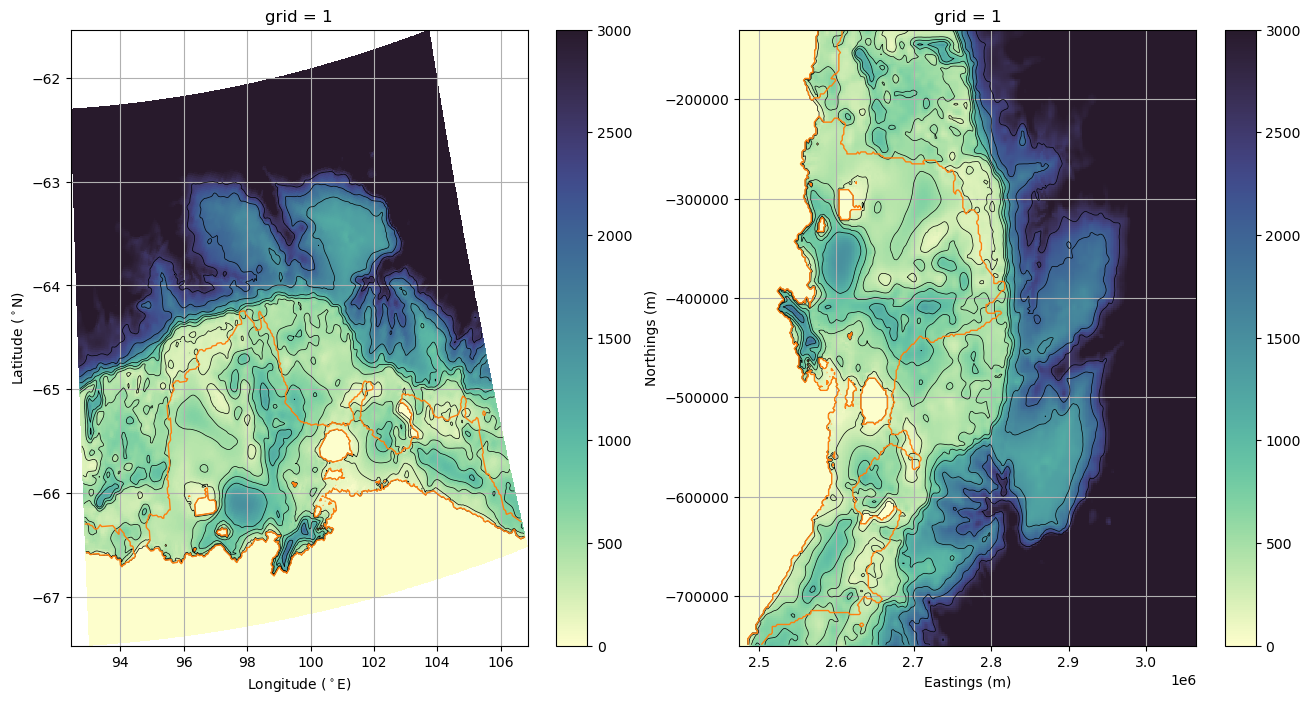

In [21]:

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.17, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[16,8])
ax = None


ax = fig.add_subplot(gs[0,0])

(ds_shackleton.h*ds_shackleton.mask_rho).plot(x='lon_rho',y='lat_rho',cmap='cmo.deep')
(ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(x='lon_rho',y='lat_rho',colors='k',linewidths=0.5,levels=[0,250,500,750,1000,1500,2000,2500])
(ds_shackleton.zice*ds_shackleton.mask_rho).plot.contour(x='lon_rho',y='lat_rho',colors='C1',linestyles='-',linewidths=1,levels=(-1,0))

ax.set_xlabel(r'Longitude ($^\circ$E)')
ax.set_ylabel(r'Latitude ($^\circ$N)')
ax.grid()

ax = fig.add_subplot(gs[0,1])

(ds_shackleton.h*ds_shackleton.mask_rho).plot(x='x_rho',y='y_rho',cmap='cmo.deep')
(ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(x='x_rho',y='y_rho',colors='k',linewidths=0.5,levels=[0,250,500,750,1000,1500,2000,2500])
(ds_shackleton.zice*ds_shackleton.mask_rho).plot.contour(x='x_rho',y='y_rho',colors='C1',linestyles='-',linewidths=1,levels=(-1,0))

ax.set_xlabel(r'Eastings (m)')
ax.set_ylabel(r'Northings (m)')
ax.grid()

Now let's extract some time series at a single point. We have to first define a function to extract the nearest point.

In [22]:

def extract_closest_ROMS(lon_target,lat_target,lon_field,lat_field):

    lat_diffs = np.abs(lat_field - lat_target)
    lon_diffs = np.abs(lon_field - lon_target)

    pyth_dist = (lat_diffs**2+lon_diffs**2)**0.5

    where = np.where(pyth_dist == pyth_dist.min())
    where_xi = where[1]
    where_eta = where[0]
    print('selected (xi,eta) at: (',where_xi,where_eta,') with lon/lat at: (',lon_field.isel(xi_rho=where_xi,eta_rho=where_eta).values,lat_field.isel(xi_rho=where_xi,eta_rho=where_eta).values,')')
    return where_xi,where_eta



Now choose an example location and let's plot some time series

In [23]:
lat_where = -65
lon_where = 100

where_xi,where_eta = extract_closest_ROMS(lon_where,lat_where,ds_shackleton.lon_rho,ds_shackleton.lat_rho)

selected (xi,eta) at: ( [120] [135] ) with lon/lat at: ( [[100.00196246]] [[-65.00515558]] )


Text(0.5, 0.98, 'Timeseries at 100.0,-65.0 at depth: 3.3 m')

<Figure size 640x480 with 0 Axes>

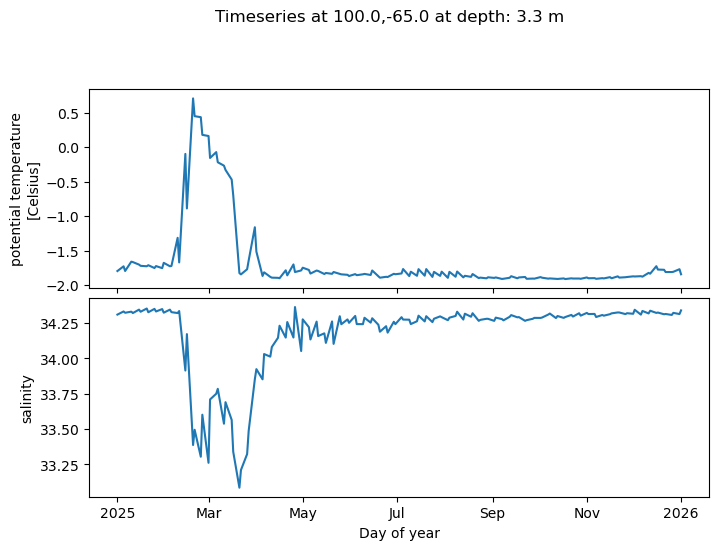

In [24]:

gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.17, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[8,8])
ax = None


ax = fig.add_subplot(gs[0,0])
ds_shackleton.temp.isel(xi_rho=where_xi,eta_rho=where_eta).isel(s_rho=-1).plot()
ax.set_xlabel('')
ax.set_title('')

ax = fig.add_subplot(gs[1,0])
ds_shackleton.salt.isel(xi_rho=where_xi,eta_rho=where_eta).isel(s_rho=-1).plot()
ax.set_title('')

# ax = fig.add_subplot(gs[2,0])
# ds_shackleton.u.isel(xi_rho=where_xi,eta_rho=where_eta).isel(s_rho=0).plot()

ax.set_xlabel('Day of year')

where_is_depth=ds_shackleton.z_rho0.isel(xi_rho=where_xi,eta_rho=where_eta).isel(s_rho=-1).values.round(1)[0][0]
where_is_lon=ds_shackleton.lon_rho.isel(xi_rho=where_xi,eta_rho=where_eta).values.round(1)[0][0]
where_is_lat=ds_shackleton.lat_rho.isel(xi_rho=where_xi,eta_rho=where_eta).values.round(1)[0][0]

plt.suptitle('Timeseries at '+str(where_is_lon)+','+str(where_is_lat)+' at depth: '+str(-where_is_depth)+' m')

Plot multiple lines for multiple depths

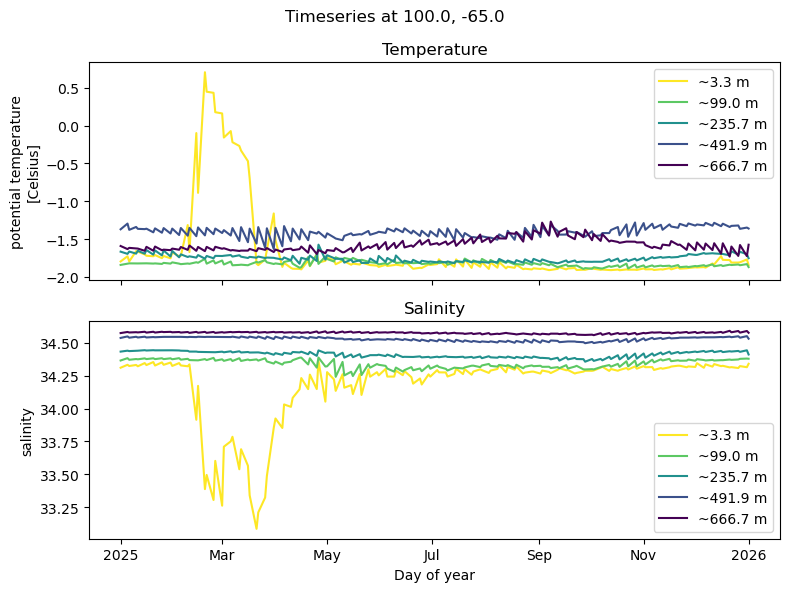

In [25]:
# Define target depths
which_depths = np.array([5, 100, 250, 500,1000])

# Get model depths at the selected location
z_levels = ds_shackleton.z_rho0.isel(xi_rho=where_xi, eta_rho=where_eta).values[:, 0][0]  # Extract the vertical profile
z_levels = -z_levels  # Convert to positive depths

# Find nearest depth indices
nearest_indices = [np.argmin(np.abs(z_levels - d)) for d in which_depths]

# Set up figure with 2 rows (temp, salinity)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True)
colors = plt.cm.viridis_r(np.linspace(0, 1, len(which_depths)))  # Generate colors for each depth

# Plot temperature (row 1)
ax_temp = axes[0]
for depth, idx, color in zip(which_depths, nearest_indices, colors):
    ds_shackleton.temp.isel(xi_rho=where_xi, eta_rho=where_eta, s_rho=idx).plot(ax=ax_temp, color=color, label=f'~{z_levels[idx]:.1f} m')
ax_temp.set_title("Temperature")
ax_temp.set_xlabel("")
ax_temp.legend()

# Plot salinity (row 2)
ax_salt = axes[1]
for depth, idx, color in zip(which_depths, nearest_indices, colors):
    ds_shackleton.salt.isel(xi_rho=where_xi, eta_rho=where_eta, s_rho=idx).plot(ax=ax_salt, color=color, label=f'~{z_levels[idx]:.1f} m')
ax_salt.set_title("Salinity")
ax_salt.set_xlabel("Day of year")
ax_salt.legend()

# Add overall title
where_is_lon = ds_shackleton.lon_rho.isel(xi_rho=where_xi, eta_rho=where_eta).values.round(1)[0][0]
where_is_lat = ds_shackleton.lat_rho.isel(xi_rho=where_xi, eta_rho=where_eta).values.round(1)[0][0]
plt.suptitle(f'Timeseries at {where_is_lon}, {where_is_lat}')

plt.tight_layout()
plt.show()

Let's add current vectors, first we have to rotate them to the lat/lon grid

In [26]:

U = ds_shackleton.u + 1j*ds_shackleton.v
rotation_factor = np.exp(1j*ds_shackleton.angle)
rotated_velocity = U * rotation_factor
# Extract the real and imaginary parts (rotated u and v components)
u_lonlat = np.real(rotated_velocity)
v_lonlat = np.imag(rotated_velocity)

/jobfs/137232697.gadi-pbs/ipykernel_4026877/89554000.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

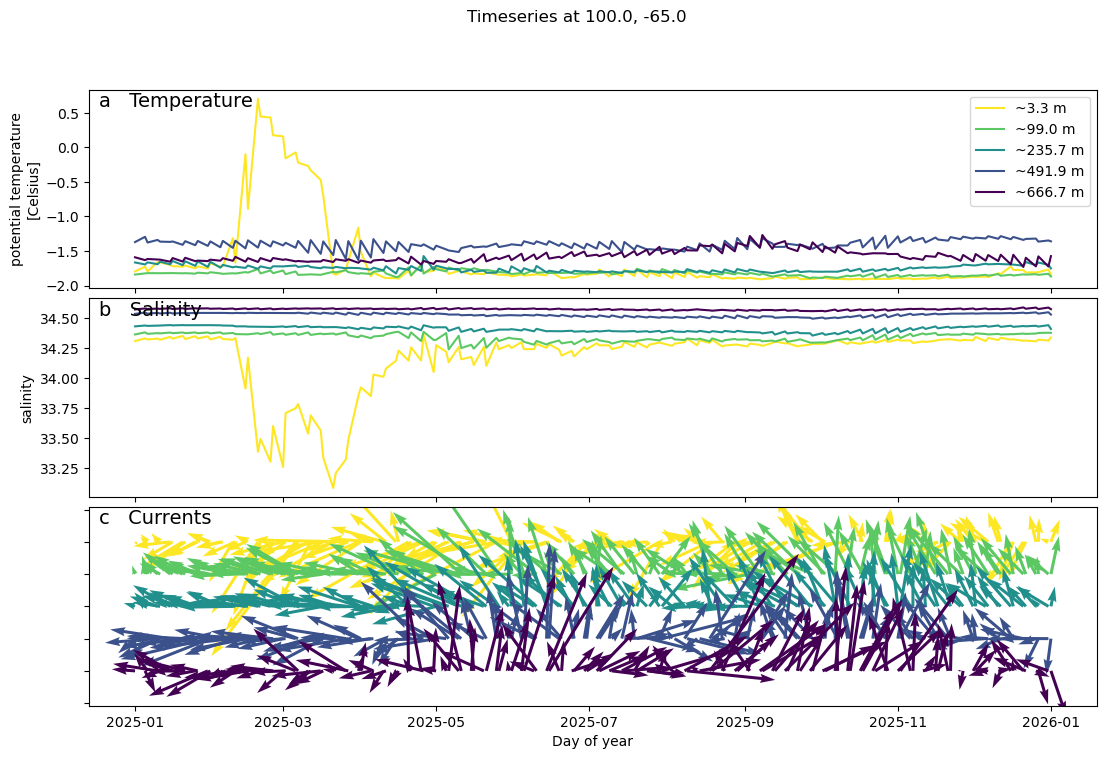

In [27]:
# Define target depths
which_depths = np.array([5, 100, 250, 500,1000])

# Get model depths at the selected location
z_levels = ds_shackleton.z_rho0.isel(xi_rho=where_xi, eta_rho=where_eta).values[:, 0][0]  # Extract the vertical profile
z_levels = -z_levels  # Convert to positive depths

# Find nearest depth indices
nearest_indices = [np.argmin(np.abs(z_levels - d)) for d in which_depths]


colors = plt.cm.viridis_r(np.linspace(0, 1, len(which_depths)))  # Generate colors for each depth


gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.17, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[13,8])
ax = None

# Plot temperature (row 1)
ax_temp = fig.add_subplot(gs[0,0])
for depth, idx, color in zip(which_depths, nearest_indices, colors):
    ds_shackleton.temp.isel(xi_rho=where_xi, eta_rho=where_eta, s_rho=idx).plot(ax=ax_temp, color=color, label=f'~{z_levels[idx]:.1f} m')
ax_temp.text(0.01,0.99,"a   Temperature", transform=ax_temp.transAxes,fontsize=14, va='top')
ax_temp.set_xlabel("")
ax_temp.legend()
ax_temp.set_title('')

# Plot salinity (row 2)
ax_salt = fig.add_subplot(gs[1,0])
for depth, idx, color in zip(which_depths, nearest_indices, colors):
    ds_shackleton.salt.isel(xi_rho=where_xi, eta_rho=where_eta, s_rho=idx).plot(ax=ax_salt, color=color, label=f'~{z_levels[idx]:.1f} m')
ax_salt.text(0.01,0.99,"b   Salinity", transform=ax_salt.transAxes,fontsize=14, va='top')
ax_salt.set_title('')

# Plot currents (row 3)
ax_curr = fig.add_subplot(gs[2,0])
for depth, idx, color,y_pos in zip(which_depths, nearest_indices, colors,range(len(which_depths))):
    ax_curr.quiver(ds_shackleton.date.values,np.ones(len(ds_shackleton.date.values))*y_pos*2,
           u_lonlat.isel(xi_rho=where_xi, eta_rho=where_eta, s_rho=idx).squeeze(),
           v_lonlat.isel(xi_rho=where_xi, eta_rho=where_eta, s_rho=idx).squeeze(), color=color, label=f'~{z_levels[idx]:.1f} m', width=0.003, headwidth=3)
ax_curr.text(0.01,0.99,"c   Currents", transform=ax_curr.transAxes,fontsize=14, va='top')
ax_curr.set_xlabel("Day of year")
# ax_curr.legend()
y_min, y_max = ax_curr.get_ylim()
y_range = y_max - y_min
new_y_min = y_min - 0.2 * y_range
new_y_max = y_max + 0.2 * y_range
ax_curr.set_ylim(new_y_min, new_y_max)
ax_curr.set_title('')
ax_curr.set_yticklabels([])
ax_curr.invert_yaxis()

# Add overall title
where_is_lon = ds_shackleton.lon_rho.isel(xi_rho=where_xi, eta_rho=where_eta).values.round(1)[0][0]
where_is_lat = ds_shackleton.lat_rho.isel(xi_rho=where_xi, eta_rho=where_eta).values.round(1)[0][0]
plt.suptitle(f'Timeseries at {where_is_lon}, {where_is_lat}')

plt.tight_layout()
plt.show()

Now, make some vertical hovmoller plots for the same location.

/jobfs/137232697.gadi-pbs/ipykernel_4026877/667645348.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

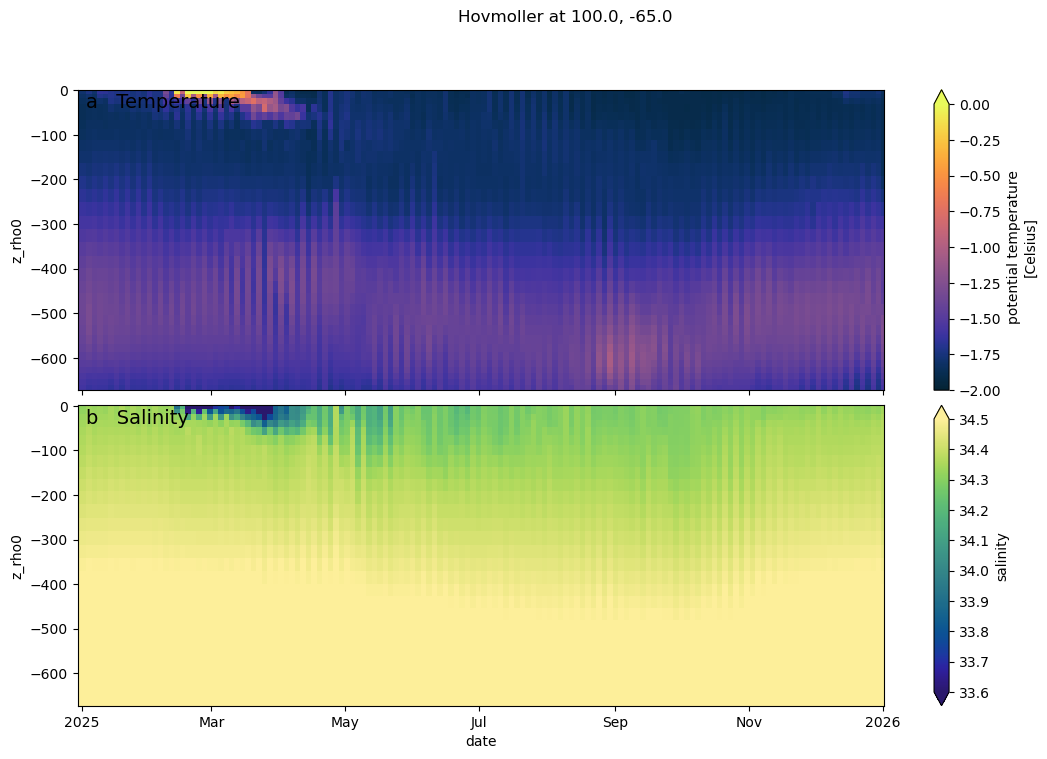

In [28]:

gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.17, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[13,8])
ax = None

# Plot temperature (row 1)
ax_temp = fig.add_subplot(gs[0,0])
ds_shackleton.temp.isel(xi_rho=where_xi, eta_rho=where_eta).squeeze().T.plot(ax=ax_temp, y='z_rho0',cmap='cmo.thermal',vmin=-2,vmax=0)
ax_temp.text(0.01,0.99,"a   Temperature", transform=ax_temp.transAxes,fontsize=14, va='top')
ax_temp.set_xlabel("")
ax_temp.set_xticklabels([])
ax_temp.set_title('')

# Plot salinity (row 2)
ax_salt = fig.add_subplot(gs[1,0])
ds_shackleton.salt.isel(xi_rho=where_xi, eta_rho=where_eta).squeeze().T.plot(ax=ax_salt, y='z_rho0', cmap='cmo.haline',vmin=33.6,vmax=34.5)
ax_salt.text(0.01,0.99,"b   Salinity", transform=ax_salt.transAxes,fontsize=14, va='top')
ax_salt.set_title('')
ax_curr.set_xlabel("Day of year")


# Add overall title
where_is_lon = ds_shackleton.lon_rho.isel(xi_rho=where_xi, eta_rho=where_eta).values.round(1)[0][0]
where_is_lat = ds_shackleton.lat_rho.isel(xi_rho=where_xi, eta_rho=where_eta).values.round(1)[0][0]
plt.suptitle(f'Hovmoller at {where_is_lon}, {where_is_lat}')

plt.tight_layout()
plt.show()